# How to perform rigid alignment

This notebook shows how to perform rigid alignment by aligning a mesh to itself after a random affine transformation.

Two cases are considered:

1. assumes unknown point correspondences
2. assumes points are in correspondence

The results show that known correspondences are very valuable information and should be taken advantage of.

In [1]:
import numpy as np
import pyvista as pv
from scipy.spatial.transform import Rotation

import polpo.preprocessing.dict as ppdict
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.adapter import PointCloudAdapter
from polpo.preprocessing.mesh.registration import PvAlign, RigidAlignment
from polpo.preprocessing.point_cloud.registration import (
    CorrespondenceBasedRigidAlignment,
)

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

## Load and manipulate data

In [3]:
mesh_loader = MeshLoader(
    subject_subset=["01"],
    struct_subset=["L_Hipp"],
    session_subset=[1],
    derivative="enigma",
    as_mesh=True,
) + ppdict.ExtractUniqueKey(nested=True)

target = mesh_loader()

Apply a random affine transform to the original mesh.

In [4]:
transform = pv.Transform()
transform.rotate(Rotation.random(), point=target.center_of_mass())
transform.translate(np.random.random(3) * 10)

source = target.transform(transform, inplace=False)

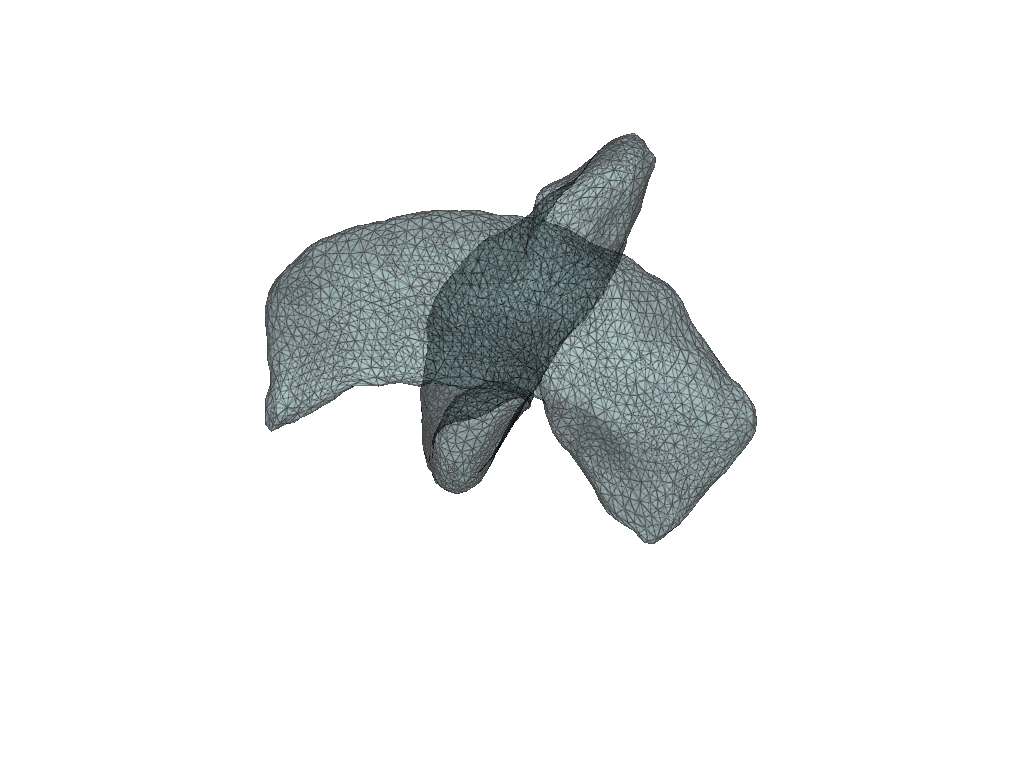

In [5]:
pl = pv.Plotter(border=False)

for mesh in [source, target]:
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

## Unknown point correspondences

`PvAlign` assumes correspondences are unknown.

In [6]:
pv_align = PvAlign(target=target, max_iterations=500)

aligned_source = pv_align(source)

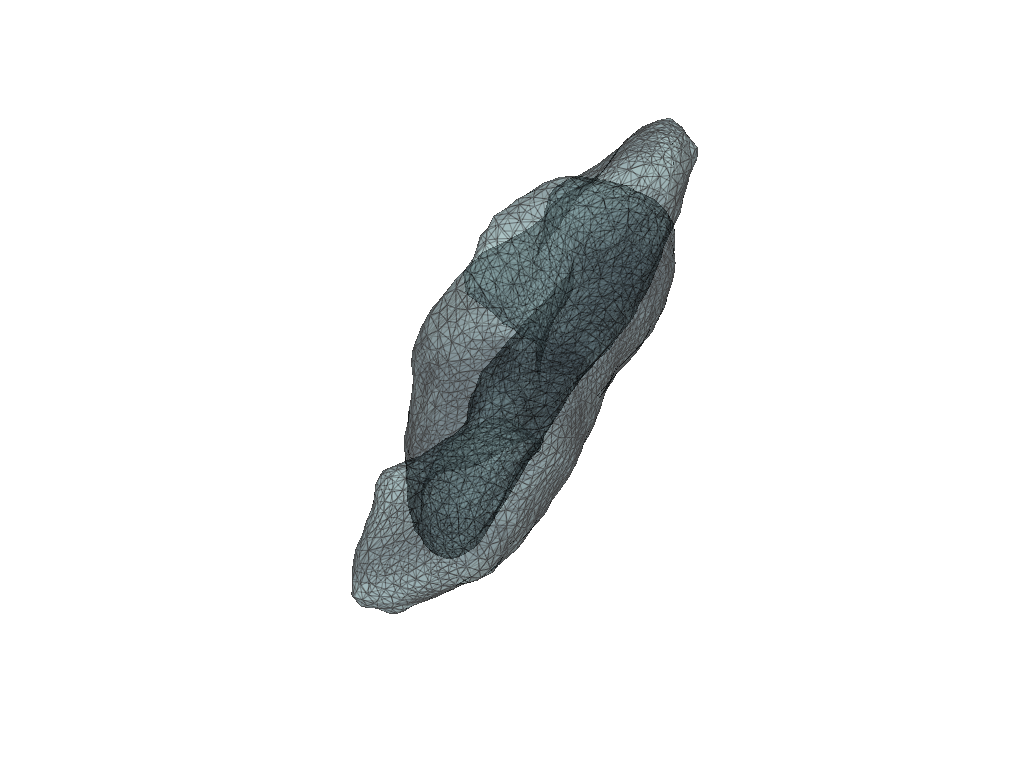

In [7]:
pl = pv.Plotter(border=False)

for mesh in [aligned_source, target]:
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

## Known point correspondences

`kabsch_umeyama` assumes correspondences are known.

In [8]:
template_faces = np.array(target.faces).reshape(-1, 4)[:, 1:]

In [9]:
template_faces = np.array(target.faces).reshape(-1, 4)[:, 1:]

mesh2points, points2mesh = PointCloudAdapter.build_pipes(template_faces)
align = PointCloudAdapter(
    CorrespondenceBasedRigidAlignment(target=mesh2points(target)),
    mesh2points,
    points2mesh,
)

aligned_source = align(source)

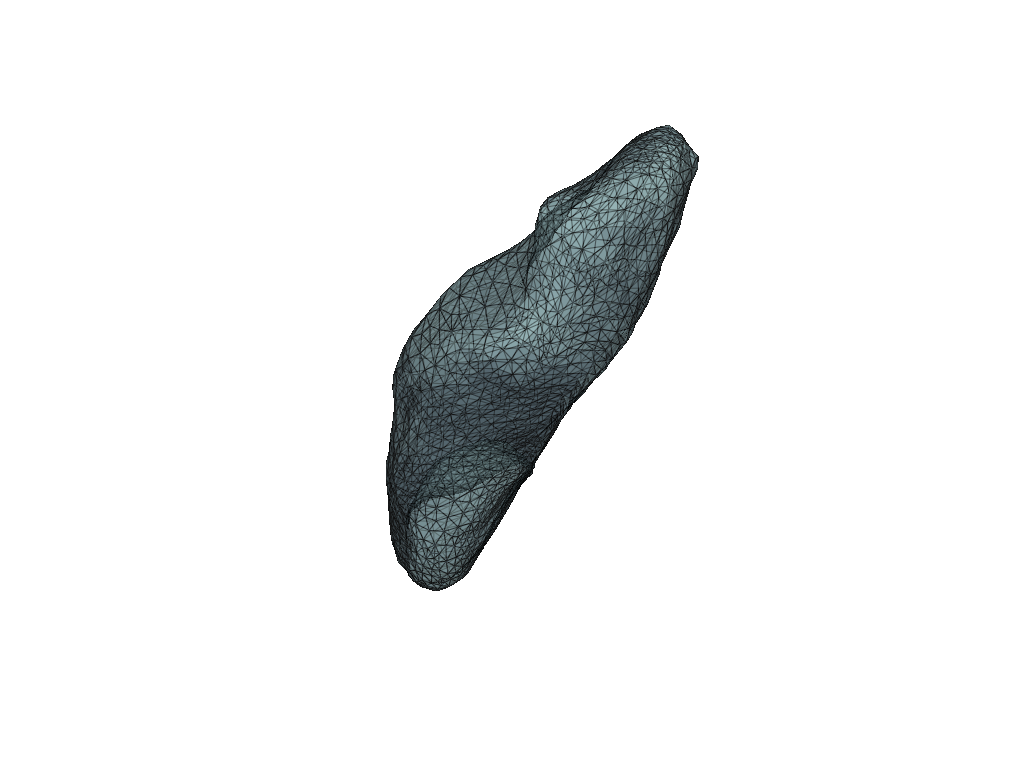

In [10]:
pl = pv.Plotter(border=False)

for mesh in [aligned_source, target]:
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

## Syntax sugar

`RigidAlignment` can be used to obtain the same results as above.

In [11]:
pv_align = RigidAlignment(target=target, max_iterations=500)

aligned_source = pv_align(source)

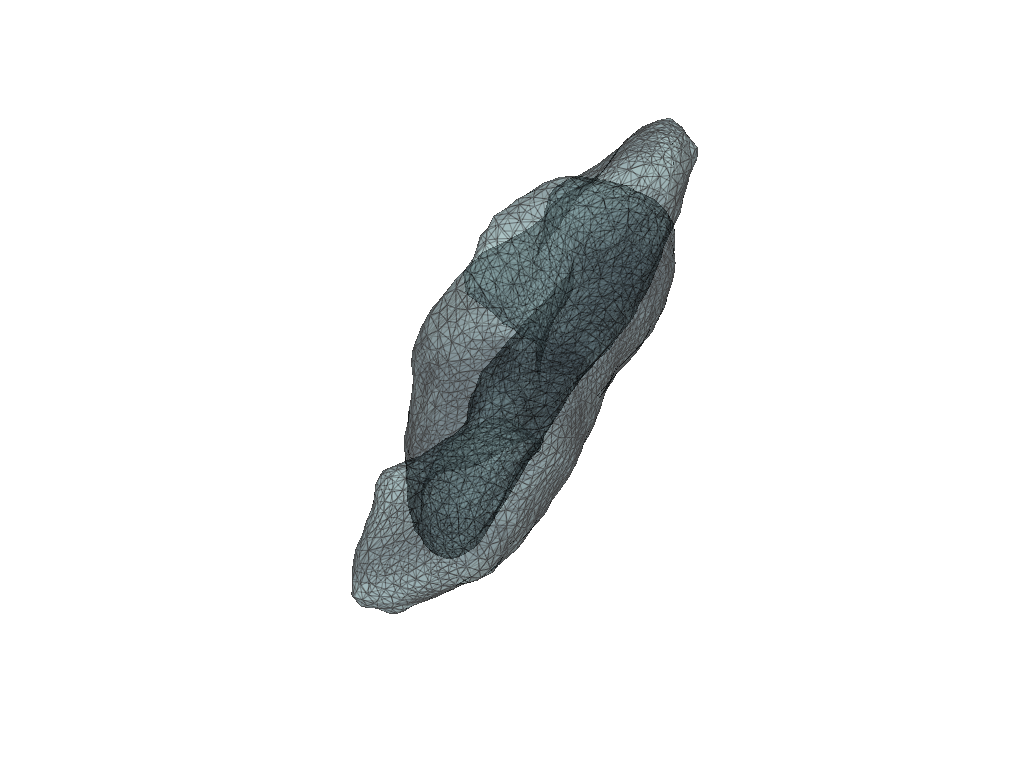

In [12]:
pl = pv.Plotter(border=False)

for mesh in [aligned_source, target]:
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

In [13]:
align = RigidAlignment(target=target, known_correspondences=True)

aligned_source = align(source)

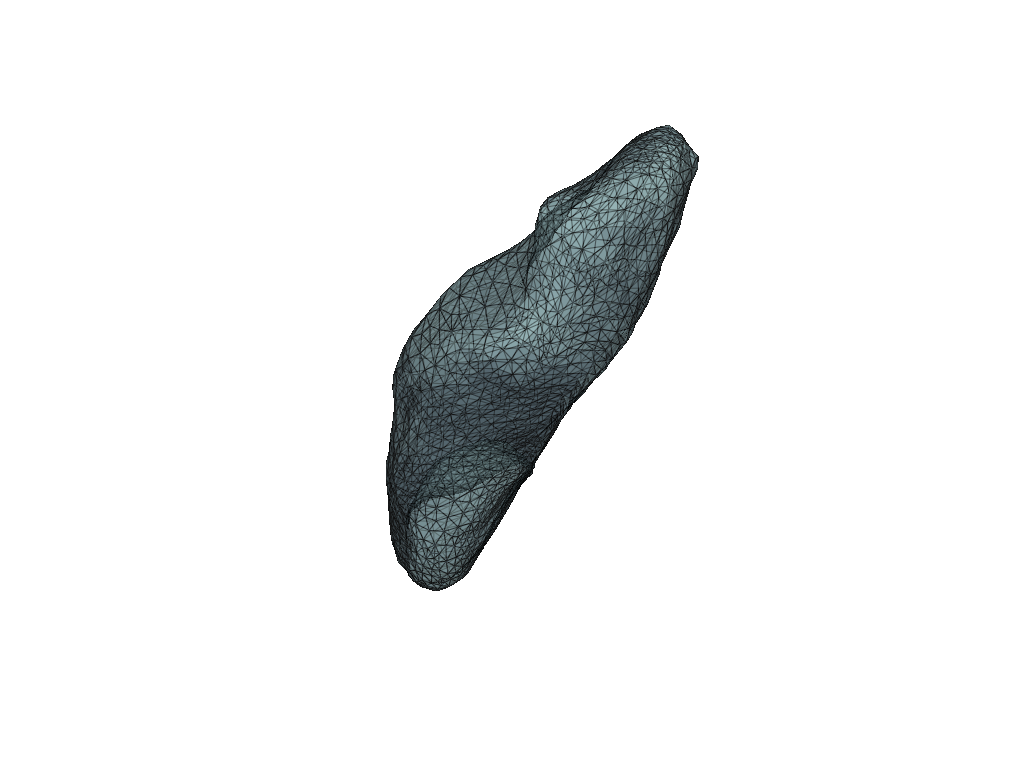

In [14]:
pl = pv.Plotter(border=False)

for mesh in [aligned_source, target]:
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()